In [ ]:
# import tensorflow as tf

In [ ]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import numpy as np

from stog.utils.params import Params
from stog.data.dataset_builder import dataset_from_params, iterator_from_params
from stog.data.vocabulary import Vocabulary
from stog.training.trainer import Trainer
from stog.data.dataset import Batch
from model.text_to_amr import TextToAMR

from tensorflow.keras.layers import Embedding, Input, Dense, Flatten, LSTM, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import MeanSquaredError

[2020-02-29 15:33:43,450 INFO] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


In [4]:
params = Params.from_file("../model/model_params.yaml")

/home/adylanrff/Documents/Kuliah/TA/amr_parser/stog/utils/params.py:104: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  dict_merge.dict_merge(params_dict, yaml.load(f))


In [5]:
data_params = params['data']
dataset = dataset_from_params(data_params)

[2020-02-29 15:33:45,036 INFO] Building train datasets ...
[2020-02-29 15:33:45,037 ERROR] Model name 'data/bert-base-cased/bert-base-cased-vocab.txt' was not found in model name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese). We assumed 'data/bert-base-cased/bert-base-cased-vocab.txt' was a path or url but couldn't find any file associated to this path or url.
0it [00:00, ?it/s][2020-02-29 15:33:45,039 INFO] Reading instances from lines in file at: ../data/raw/amr.txt.features
[2020-02-29 15:33:45,100 INFO] POS tag coverage: 0.3087 (184/596)
40it [00:00, 644.97it/s]
[2020-02-29 15:33:45,102 INFO] Building dev datasets ...
[2020-02-29 15:33:45,102 ERROR] Model name 'data/bert-base-cased/bert-base-cased-vocab.txt' was not found in model name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-

In [6]:
train_data = dataset['train']
dev_data = dataset.get('dev')
test_data = dataset.get('test')

In [7]:
vocab_params = params.get('vocab', {})
vocab = Vocabulary.from_instances(instances=train_data, **vocab_params)
vocab.save_to_files("../data/processed/serialization")

dataset = Batch(train_data)
dataset.index_instances(vocab)
dataset.index_instances(vocab)

# print(dataset.as_tensor_dict()['src_tokens']['encoder_tokens'][1].numpy())
# print(dataset.as_tensor_dict()['tgt_tokens']['decoder_tokens'][1].numpy())
# print(dataset.get_padding_lengths())
# print(dataset.as_tensor_dict())

for key in dataset.as_tensor_dict():
    print(key)
    content = dataset.as_tensor_dict()[key]
    if isinstance(content, dict):
        for inner_key in content:
            print("  ", inner_key)

train_iterator, dev_iterater, test_iterater = iterator_from_params(vocab, data_params['iterator'])

train_dataset = Batch(train_data)
train_dataset.index_instances(vocab)

test_dataset = Batch(test_data)
test_dataset.index_instances(vocab)

train_dataset = train_dataset.as_tensor_dict()
test_dataset = test_dataset.as_tensor_dict()

[2020-02-29 15:33:45,248 INFO] Fitting token dictionary from dataset.
100%|██████████| 40/40 [00:00<00:00, 3712.02it/s]
[2020-02-29 15:33:45,264 WARNING] vocabulary serialization directory ../data/processed/serialization is not empty


src_tokens
   encoder_tokens
   encoder_characters
src_must_copy_tags
tgt_tokens
   decoder_tokens
   decoder_characters
src_pos_tags
tgt_pos_tags
tgt_copy_indices
tgt_copy_mask
tgt_copy_map
src_copy_indices
src_copy_map
head_tags
head_indices


In [8]:
print(vocab)

Vocabulary with namespaces:
 	Non Padded Namespaces: {'must_copy_tags', 'coref_tags'}
 	Namespace: encoder_token_ids, Size: 334 
 	Namespace: encoder_token_characters, Size: 39 
 	Namespace: decoder_token_ids, Size: 283 
 	Namespace: decoder_token_characters, Size: 65 
 	Namespace: pos_tags, Size: 16 
 	Namespace: head_tags, Size: 35 



###### Test Model

In [9]:
text_to_amr = TextToAMR(vocab)
encoder_input, decoder_input, generator_input, parser_input = text_to_amr.prepare_input(train_dataset)

ENCODER TOKEN VOCAB SIZE:  334
DECODER TOKEN VOCAB SIZE:  283
ENCODER_INPUT
bert_token: None
token_subword_index: None
token: (40, 25)
pos_tag: (40, 25)
must_copy_tag: (40, 25)
char: (40, 25, 14)

DECODER_INPUT
token: (40, 28)
pos_tag: (40, 28)
char: (40, 28, 17)
coref: (40, 28)

GENERATOR_INPUT
vocab_targets: (40, 28)
coref_targets: (40, 28)
coref_attention_maps: (40, 28, 29)
copy_targets: (40, 28)
copy_attention_maps: (40, 25, 27)

PARSER_INPUT
edge_heads: (40, 27)
edge_labels: (40, 27)
corefs: (40, 28)
mask: (40, 28)



In [10]:
model = text_to_amr.generate_model()
model.compile(optimizer='rmsprop', loss="mean_squared_error")

enc_output:  (40, 25, 400)
X:  (40, 28, 200)
X:  (40, 28, 400)
STATES:  (40, 28, 400)
source_copy_attentions:  (40, 28, 25)
target_copy_attentions:  (40, 28, 28)
DECODER_OUTPUT:  (40, 28, 400)
DECODER_HIDDEN:  (28, 40, 800)
Source copy Attentions:  (40, 28, 25)
Target copy attentions:  (40, 28, 28)
HIDDENS:  (40, 28, 400)
SOURCE ATTENTION MAP:  (40, 25, 27)
TARGET ATTENTION MAP:  (40, 28, 29)
p:  (40, 28, 3)
p_copy_source:  (40, 28)
p_copy_target:  (40, 28)
p_generate:  (40, 28)
scores:  (40, 28, 283)
scaled_vocab_probs:  (40, 28, 283)
scaled_copy_source_probs:  (40, 28, 27)
scaled_copy_target_probs:  (40, 28, 29)
(40, 28)


In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
token_encoder_input (InputLayer [(40, 25)]           0                                            
__________________________________________________________________________________________________
pos_encoder_input (InputLayer)  [(40, 25)]           0                                            
__________________________________________________________________________________________________
token_decoder_input (InputLayer [(40, 28)]           0                                            
__________________________________________________________________________________________________
encoder (Encoder)               ((40, 25, 400), ((40 676600      token_encoder_input[0][0]        
______________________________________________________________________________________________

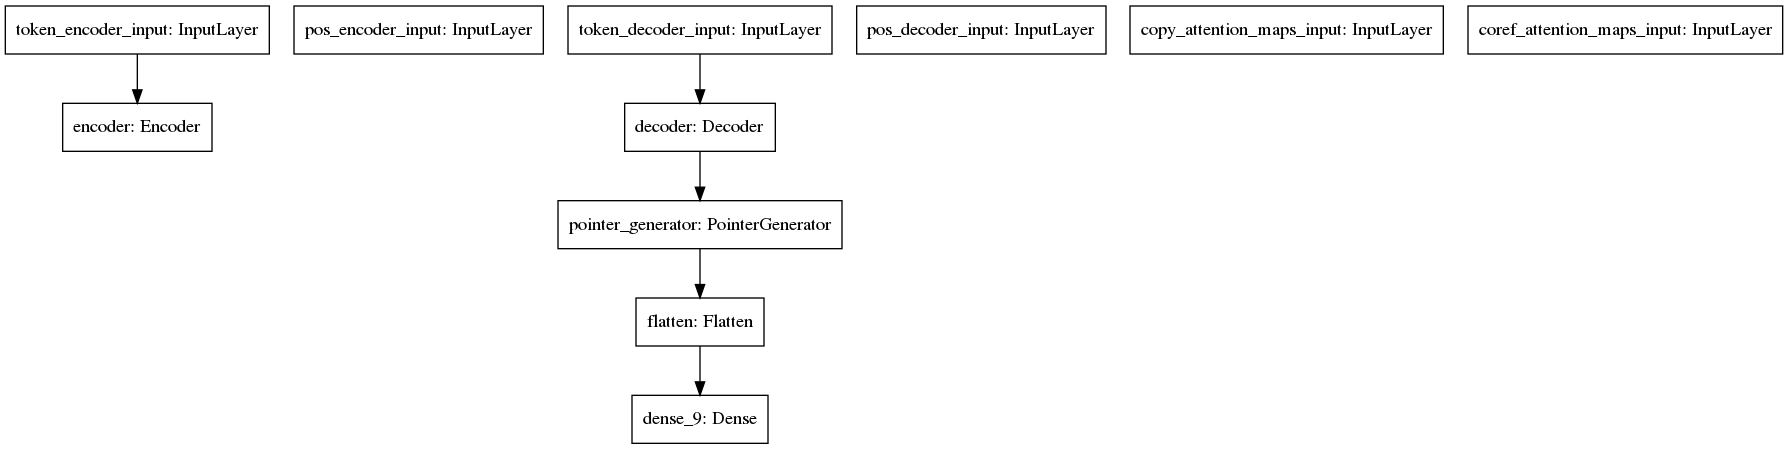

In [12]:
plot_model(model)

In [17]:
token_encoder_input = encoder_input.get('token')
pos_encoder_input = encoder_input.get('pos_tag')
token_decoder_input = decoder_input.get('token')
pos_decoder_input = decoder_input.get('pos_tag')
copy_attention_map_input = generator_input.get('copy_attention_maps')
coref_attention_map_input = generator_input.get('coref_attention_maps')

model_input = [
    token_encoder_input, 
    pos_encoder_input, 
    token_decoder_input, 
    pos_decoder_input, 
    copy_attention_map_input, 
    coref_attention_map_input
]

model.fit(model_input, np.asarray([1 for _ in range(len(model_input[0]))]), epochs=1)

Train on 40 samples
enc_output:  (40, 25, 400)
X:  (40, 28, 200)
X:  (40, 28, 400)
STATES:  (40, 28, 400)
source_copy_attentions:  (40, 28, 25)
target_copy_attentions:  (40, 28, 28)
HIDDENS:  (40, 28, 400)
SOURCE ATTENTION MAP:  (40, 25, 27)
TARGET ATTENTION MAP:  (40, 28, 29)
p:  (40, 28, 3)
p_copy_source:  (40, 28)
p_copy_target:  (40, 28)
p_generate:  (40, 28)
scores:  (40, 28, 283)
scaled_vocab_probs:  (40, 28, 283)
scaled_copy_source_probs:  (40, 28, 27)
scaled_copy_target_probs:  (40, 28, 29)
(40, 28)
enc_output:  (40, 25, 400)
X:  (40, 28, 200)
X:  (40, 28, 400)
STATES:  (40, 28, 400)
source_copy_attentions:  (40, 28, 25)
target_copy_attentions:  (40, 28, 28)
HIDDENS:  (40, 28, 400)
SOURCE ATTENTION MAP:  (40, 25, 27)
TARGET ATTENTION MAP:  (40, 28, 29)
p:  (40, 28, 3)
p_copy_source:  (40, 28)
p_copy_target:  (40, 28)
p_generate:  (40, 28)
scores:  (40, 28, 283)
scaled_vocab_probs:  (40, 28, 283)
scaled_copy_source_probs:  (40, 28, 27)
scaled_copy_target_probs:  (40, 28, 29)
(40

KeyboardInterrupt: 